In [1]:
%ls

0.BCE_70/   2.BCEDICE_70/  data_analysis.ipynb  unet.py
1.DICE_70/  chk/           __pycache__/


# Data Analysis

Data는 총 4 가지가 있다. 
- ADC (ADeno-Carcinoma)
- HGD (High-Grade Dysplasia)
- LGD (Low-Grade Dysplasia)
- NOR (Normal)

데이터의 생김새는 다음과 같다. Raw image와 masking이 된(labeled) image가 있다.
- data: \[phase\]\_IMG_[patient #].jpg
- label: \[phase\]\_MASK_[patient #].jpg

데이터들은 original data에서 검은 부분을 최대한 지운, 즉 cropped 된 상태이다. 
이미지의 사이즈는 다 달라서 resize를 해주어야 한다.

가) ADC의 데이터는 patient의 image와 mask image로 각각 data와 label로 나누어 이해하면 된다. data의 수와 그에 따라 label이 있는지 확인해보자.

나) 3개씩 뽑아서 어떤 형태인지 확인해보자.

In [2]:
# Data visualize를 위한 imports
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
# GPU 한 개만 할당을 위함
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import numpy as np
import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

pd.set_option('display.max.colwidth', 30)


# 각 이미지들이 속해 있는 경로
ADC_img_path = '/disk1/colonoscopy_dataset/cropped/ADC/'
HGD_img_path = '/disk1/colonoscopy_dataset/cropped/HGD/'
LGD_img_path = '/disk1/colonoscopy_dataset/cropped/LGD/'
NOR_img_path = '/disk1/colonoscopy_dataset/cropped/NOR/'

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [3]:
# 가) 전체 파일 수, ADC data 수와 labeled data 수 확인

ADC_file_list = os.listdir(ADC_img_path) # ADC 전체 파일 목록
HGD_file_list = os.listdir(HGD_img_path) # HGD 전체 파일 목록
LGD_file_list = os.listdir(LGD_img_path) # LGD 전체 파일 목록
NOR_file_list = os.listdir(NOR_img_path) # NOR 전체 파일 목록

ADC_data_list = [x for x in ADC_file_list if 'IMG' in x]        # ADC data 파일 목록
ADC_labeled_list = [x for x in ADC_file_list if 'MASK' in x]    # ADC mask 파일 목록

HGD_data_list = [x for x in HGD_file_list if 'IMG' in x]        # HGD data 파일 목록
HGD_labeled_list = [x for x in HGD_file_list if 'MASK' in x]    # HGD mask 파일 목록

LGD_data_list = [x for x in LGD_file_list if 'IMG' in x]        # LGD data 파일 목록
LGD_labeled_list = [x for x in LGD_file_list if 'MASK' in x]    # LGD mask 파일 목록

NOR_data_list = [x for x in NOR_file_list if 'IMG' in x]        # NOR data 파일 목록
NOR_labeled_list = [x for x in NOR_file_list if 'MASK' in x]    # NOR mask 파일 목록

totalNum_list = [len(ADC_file_list), len(HGD_file_list), len(LGD_file_list), len(NOR_file_list)]
totalData_list = [len(ADC_data_list), len(HGD_data_list), len(LGD_data_list), len(NOR_data_list)]
totalMask_list = [len(ADC_labeled_list), len(HGD_labeled_list), len(LGD_labeled_list), len(NOR_labeled_list)]

data = [totalNum_list, totalData_list, totalMask_list]
table = pd.DataFrame(data = data, index = ['Total #', 'data #', 'mask data #'], columns = ['ADC', 'HGD', 'LGD', 'NOR'])

print(table)

              ADC   HGD   LGD   NOR
Total #      1008  1000  2000  2000
data #        504   500  1000  1000
mask data #   504   500  1000  1000


[1] ADC [2] HGD [3] LGD [4] NOR


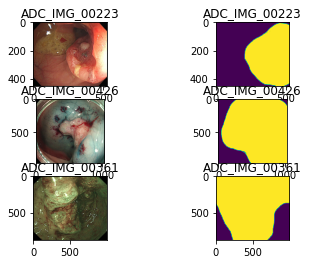

In [4]:
# 나) 3개씩 뽑아서 확인해보자.
print("[1] ADC [2] HGD [3] LGD [4] NOR") # 각 번호에 맞는 데이터를 보여준다.
#num = input()
num = '1'

path_dic = {"1": ADC_img_path, "2": HGD_img_path, "3": LGD_img_path, "4": NOR_img_path}
file_dic = {"1": ADC_data_list, "2": HGD_data_list, "3": LGD_data_list, "4": NOR_data_list}
title_dic = {"1": "ADC", "2": "HGD", "3": "LGD", "4": "NOR"}

rows = 3
columns = 2
plt.rcParams['figure.figsize'] = (8, 8)
random_file_list = (np.random.choice(file_dic[num], 3)).tolist()
match_file_list = [x.replace('IMG', 'MASK') for x in random_file_list]
# np.array(Image.open(os.path.join(self.data_dir, label_path)))
cnt = 0
for a, b in zip(random_file_list, match_file_list):
    # IMG
    cnt += 1
    img = Image.open(os.path.join(path_dic[num], a))
    #print(np.array(Image.open(os.path.join(path_dic[num], a)).resize((572,572))).min())
    ti = title_dic[num] + '_IMG_' + a[-9:-4]
    plt.subplot(rows, columns, cnt)
    plt.title(ti)
    plt.imshow(img)
    cnt += 1
    # MASK
    img = Image.open(os.path.join(path_dic[num], b))
    ti = title_dic[num] + '_IMG_' + b[-9:-4]
    #print(np.array(Image.open(os.path.join(path_dic[num], b)).resize((572,572))).shape)
    plt.subplot(rows, columns, cnt)
    plt.title(ti)
    plt.imshow(img)
plt.show()

# Dataset (train, valid) 준비

우선적으로 ADC에 대해서만 학습할 계획이다.

가) 갖고 있는 504장을 8:2으로 나누어서 dataloader를 구현하자. (train:valid)

In [5]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [6]:
# 데이터 로더를 구현하기
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None, type=None):
        self.data_dir = data_dir
        self.transform = transform
        self.type = type

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if 'MASK' in f]
        lst_input = [f for f in lst_data if 'IMG' in f]

        lst_label.sort()
        lst_input.sort()

        target_label = []
        target_input = []

        train_length = int(len(lst_input)*0.8)
        # train mode
        if type == 0:
            target_label = lst_label[:train_length]
            target_input = lst_input[:train_length]
        # test mode
        else:
            target_label = lst_label[train_length:]
            target_input = lst_input[train_length:]
        
        self.lst_label = target_label
        self.lst_input = target_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.asarray(((Image.open(os.path.join(self.data_dir, self.lst_label[index]))).resize((256,256))))
        input = np.asarray((Image.open(os.path.join(self.data_dir, self.lst_input[index])).resize((256,256))))

        # 정규화
        label[label>150] = 255
        label[label<=150] = 0
        
        label = label/255.0
        input = input/255.0

        # 이미지와 레이블의 차원 = 2일 경우(채널이 없을 경우, 흑백 이미지), 새로운 채널(축) 생성
        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        # transform이 정의되어 있다면 transform을 거친 데이터를 불러옴
        if self.transform:
            data = self.transform(data)

        return data

(256, 256, 3) (256, 256, 1)


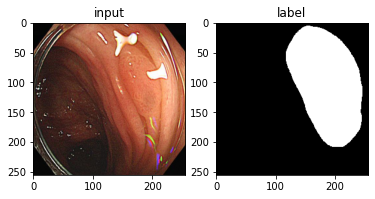

In [7]:
original_data_path = '/disk1/colonoscopy_dataset/cropped/LGD'

# 데이터로더 잘 구현되었는지 확인
dataset_train = Dataset(data_dir=original_data_path, type=0)
data = dataset_train.__getitem__(0) # 한 이미지 불러오기
input = data['input']
label = data['label']

print(input.shape, label.shape)

# 불러온 이미지 시각화
plt.subplot(122)
plt.imshow(label, cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.show()

In [8]:
class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

transform = transforms.Compose([
    #Normalization(mean=0.5, std=0.5), RandomFlip(), 
    ToTensor()
])

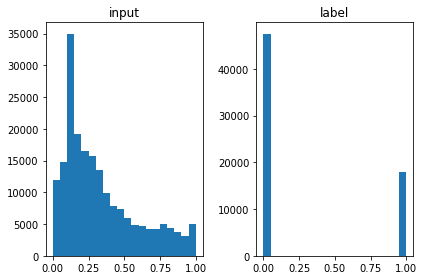

In [9]:
dataset_train = Dataset(data_dir=original_data_path, transform=transform, type=0)
data = dataset_train.__getitem__(0) # 한 이미지 불러오기
input = data['input']
label = data['label']

# 불러온 이미지 시각화
plt.subplot(122)
plt.hist(label.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()

In [10]:
## 네트워크 저장하기
def save(ckpt_dir, model, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'model': model.state_dict(), 'optim': optim.state_dict()},
               "%s/model_epoch%d.pth" % (ckpt_dir, epoch))

## 네트워크 불러오기
def load(ckpt_dir, model, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return model, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    model.load_state_dict(dict_model['model'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return model, optim, epoch

# 하이퍼파라미터

In [11]:
# 훈련 파라미터 설정하기
lr = 1e-4
batch_size = 4
num_epoch = 70

base_dir = '/home/sundongk/MyUnet'
data_dir = original_data_path
ckpt_dir = os.path.join(base_dir, "checkpoint")
log_dir = os.path.join(base_dir, "log")

In [12]:
dataset_train = Dataset(data_dir=original_data_path, transform=transform, type=0)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

dataset_val = Dataset(data_dir=original_data_path, transform=transform, type=1)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)

# 네트워크 설계

In [13]:
## 라이브러리 불러오기
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from torchvision import transforms, datasets

## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Convolution + BatchNormalization + Relu 정의하기
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True): 
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(in_channels=3, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # 확장 경로(Expansive path)
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
    
    # forward 함수 정의하기
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

# Loss 함수 정의

In [14]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

# 훈련 시작

In [15]:
import torch.nn.functional as F

# 네트워크 생성하기
model = UNet().to(device)

# 손실함수 정의하기
def calc_loss(pred, target, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce*bce_weight + dice*(1-bce_weight)

    return loss

#fn_loss = nn.BCEWithLogitsLoss().to(device)
#fn_loss = DiceLoss().to(device)

# Optimizer 설정하기
optim = torch.optim.Adam(model.parameters(), lr=lr)

# 그밖에 부수적인 variables 설정하기
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

# 네트워크 학습시키기
st_epoch = 0
# 학습한 모델이 있을 경우 모델 로드하기
model, optim, st_epoch = load(ckpt_dir=ckpt_dir, model=model, optim=optim) 

train_loss = []
val_loss = []
checkpoint_path = os.path.join(base_dir, 'chk')
best_loss = 1e10

In [16]:
for epoch in range(st_epoch + 1, num_epoch + 1):
    model.train()
    loss_arr = []
    epoch_samples = 0

    for batch, data in enumerate(loader_train, 1):
        # forward pass
        label = data['label'].to(device)
        input = data['input'].to(device)

        output = model(input)

        # backward pass
        optim.zero_grad()
        #loss = fn_loss(output, label)
        loss = calc_loss(output, label, bce_weight=0)
        loss.backward()
        optim.step()

        # 손실함수 계산
        loss_arr += [loss.item()]

    print("TRAIN: EPOCH %04d / %04d | LOSS %.4f" %
           (epoch, num_epoch, np.mean(loss_arr)))
    train_loss.append(np.mean(loss_arr))
    epoch_samples = 0
    with torch.no_grad():
        model.eval()
        loss_arr = []

        for batch, data in enumerate(loader_val, 1):
            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = model(input)

            # 손실함수 계산하기
            #loss = fn_loss(output, label)
            loss = calc_loss(output, label)
            loss_arr += [loss.item()]

        print("VALID: EPOCH %04d / %04d | LOSS %.4f" %
               (epoch, num_epoch, np.mean(loss_arr)))
        val_loss.append(np.mean(loss_arr))
        epoch_loss = np.mean(loss_arr)
        if epoch_loss < best_loss:
            print(f"saving best model to {ckpt_dir}")
            best_loss = epoch_loss
            print(best_loss)
            save(ckpt_dir=checkpoint_path, model=model, optim=optim, epoch=epoch)

    # # epoch 50마다 모델 저장하기
    # if epoch % 100 == 0:
    #     save(ckpt_dir=ckpt_dir, model=net, optim=optim, epoch=epoch)


TRAIN: EPOCH 0001 / 0070 | LOSS 0.4850
VALID: EPOCH 0001 / 0070 | LOSS 0.5910
saving best model to /home/sundongk/MyUnet/checkpoint
0.5910043442249298
TRAIN: EPOCH 0002 / 0070 | LOSS 0.4191
VALID: EPOCH 0002 / 0070 | LOSS 0.5090
saving best model to /home/sundongk/MyUnet/checkpoint
0.5090107434988022
TRAIN: EPOCH 0003 / 0070 | LOSS 0.3930
VALID: EPOCH 0003 / 0070 | LOSS 0.6096
TRAIN: EPOCH 0004 / 0070 | LOSS 0.3719
VALID: EPOCH 0004 / 0070 | LOSS 0.5261
TRAIN: EPOCH 0005 / 0070 | LOSS 0.3571
VALID: EPOCH 0005 / 0070 | LOSS 0.5419
TRAIN: EPOCH 0006 / 0070 | LOSS 0.3385
VALID: EPOCH 0006 / 0070 | LOSS 0.5457
TRAIN: EPOCH 0007 / 0070 | LOSS 0.3253
VALID: EPOCH 0007 / 0070 | LOSS 0.5550
TRAIN: EPOCH 0008 / 0070 | LOSS 0.3098
VALID: EPOCH 0008 / 0070 | LOSS 0.7044
TRAIN: EPOCH 0009 / 0070 | LOSS 0.3077
VALID: EPOCH 0009 / 0070 | LOSS 0.5598
TRAIN: EPOCH 0010 / 0070 | LOSS 0.2885
VALID: EPOCH 0010 / 0070 | LOSS 0.5765
TRAIN: EPOCH 0011 / 0070 | LOSS 0.2809
VALID: EPOCH 0011 / 0070 | LOSS 0.6

# 시각화

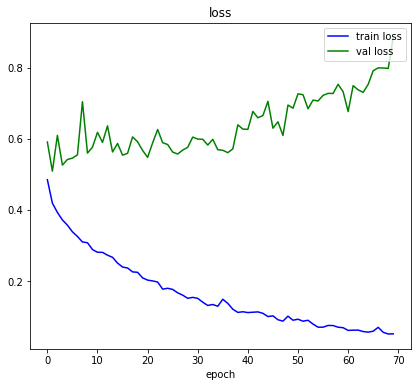

In [17]:
# Loss 시각화
plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.title('loss')
plt.xlabel('epoch')
plt.plot(train_loss, 'b', label='train loss')
plt.plot(val_loss, 'g', label='val loss')
plt.legend(loc='upper right')

plt.show()

In [23]:
checkpoint_path = os.path.join(base_dir, 'chk')
model, optim, st_epoch = load(ckpt_dir=checkpoint_path, model=model, optim=optim) 

print(st_epoch)

2


In [24]:
# Visualization
from torchvision.transforms.functional import to_pil_image

transform = transforms.Compose([
    ToTensor()
])

batch_size = 1

dataset_train = Dataset(data_dir=original_data_path, transform=transform, type=0)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

dataset_val = Dataset(data_dir=original_data_path, transform=transform, type=1)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)

def changeTensor(tensor, labelmode=0, threshold=0.1):
    image = tensor.detach().cpu().clone()
    image = image.squeeze(0)
    if labelmode == 1:
        image[image>threshold] = 1
        image[image<=threshold] = 0 
    
    return image

In [25]:
# Pixel Accuracy / Intersection Over Union / Dice coefficient(=F1 score)
def get_PA_IOU_and_DICE(pred, true, TH):
    pred = changeTensor(pred, 1, TH)
    true = changeTensor(true, 1, TH)
    
    pred = pred.detach().cpu().numpy().reshape(-1)
    true = true.detach().cpu().numpy().reshape(-1)
    
    size = len(pred)^2
    pa = (size - np.logical_xor(true, pred).sum()) / size
    
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    
    if np.sum(union) == 0:
        iou = -1
    else:
        iou = np.sum(intersection) / np.sum(union)

    intersection = (pred * true).sum()
    dice = (2.*intersection + 1) / (pred.sum() + true.sum() + 1)

    return pa, iou, dice

In [26]:
TH = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
# Results(various metrics) for Training set
for th in TH:
    with torch.no_grad():
        model.eval()
        acc_PA = []
        acc_IOU = []
        acc_DICE = []
        
        for batch, data in enumerate(loader_val, 1):
            label = data['label'].to(device)
            input = data['input'].to(device)
            output = model(input)
        
            # Calculate PA & IOU & Dice coefficient(=F1 score)
            pa, iou, dice = get_PA_IOU_and_DICE(output, label, th)
            acc_PA.append(pa)
            acc_IOU.append(iou)
            acc_DICE.append(dice)

            # # 불러온 이미지 시각화
            # input_image_example = plt.subplot(1,3,1)
            # input_image_example.set_title('input Image Example')
            # plt.imshow(to_pil_image(changeTensor(input)))

            # label_image_example = plt.subplot(1,3,2)
            # label_image_example.set_title('Label Image Example')
            # plt.imshow(to_pil_image(changeTensor(label)), cmap='gray')

            # test_image_example = plt.subplot(1,3,3)
            # test_image_example.set_title('Test Image Example')
            # plt.imshow(to_pil_image(changeTensor(output, 1)), cmap='gray')

            # plt.show()
        print(np.round(np.mean(acc_PA),4))
        print(np.round(np.mean(acc_IOU),4))
        print(np.round(np.mean(acc_DICE), 4))
        print("-"*10)
            

0.8066
0.4582
0.5988
----------
0.807
0.4575
0.5981
----------
0.8074
0.4568
0.5974
----------
0.8077
0.4562
0.5968
----------
0.8079
0.4557
0.5962
----------
0.8082
0.4551
0.5955
----------
0.8084
0.4544
0.5948
----------
0.8087
0.4538
0.5941
----------
0.8089
0.4531
0.5934
----------


# 네트워크 파라미터 요약

In [22]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,